In [442]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests
import scipy.optimize as sopt
import scipy.stats as s
import sklearn.metrics as sk

In [443]:
Case = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/Case_Ripulite.csv')
Lavoratori = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/Lavoratori_Pulito.csv')
Permessi = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/Permessi_Ripuliti.csv')
PIL = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/PIL_Ripuliti.csv')
Popolazione = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/Popolazione_Ripulita.csv')
Tassi = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/Tassi_Ripuliti.csv')
Turisti = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/Turisti_ripuliti.csv')

In [444]:
datasets = [Case , Lavoratori , Permessi , PIL , Popolazione , Tassi , Turisti]

for i in datasets : 
    i.TIME = pd.to_datetime(i.TIME)
    i.TIME = i.TIME.apply(lambda dt : dt.replace(day = 1))

for i in datasets : print(i.TIME.min() , '\t', i.TIME.max())

1947-03-01 00:00:00 	 2022-12-01 00:00:00
1992-12-01 00:00:00 	 2020-12-01 00:00:00
2000-03-01 00:00:00 	 2022-12-01 00:00:00
1995-03-01 00:00:00 	 2022-12-01 00:00:00
1995-03-01 00:00:00 	 2021-12-01 00:00:00
1995-03-01 00:00:00 	 2022-12-01 00:00:00
1990-03-01 00:00:00 	 2022-12-01 00:00:00


In [445]:
tot = Case
datasets = [ Lavoratori , Permessi , PIL , Popolazione , Tassi , Turisti]

for i in datasets : tot = tot.merge(i , on = 'TIME')

datasets = [Case , Lavoratori , Permessi , PIL , Popolazione , Tassi]
tot.drop_duplicates(subset = 'TIME', inplace = True , ignore_index=True)
tot.drop(columns=['Year','Tipo aggregato (milioni di euro)' , 'Tipo dato' , 'Edizione_x' , 'Edizione_y' , 'Tipologia edilizia' , 'Valutazione' , 'Entity' , 'Code'] , inplace = True)
tot.rename(columns = {'Case_Nuove' : 'Permessi' , 'Population (historical estimates)' : 'Popolazione'} , inplace = True )

tot.head()

,TIME,Index_Case,Lavoratori,Permessi,PIL,Popolazione,Tassi,Turisti
0,2000-03-01,76.3039,21404.923,44732,304332.9,56966400,1.957367,23347219
1,2000-06-01,76.4064,21536.880,47040,309182.0,56966400,2.067367,34612332
2,2000-09-01,76.9951,21676.266,44421,311585.5,56966400,2.116367,72850384
3,2000-12-01,77.3332,21796.031,48231,318345.9,56966400,2.115300,25390345
4,2001-03-01,77.5702,21887.499,44842,322548.8,56994992,2.036567,24704999


In [446]:
Media = tot[tot.TIME.dt.year == 2010] 
tot.Lavoratori = tot.Lavoratori/ Media.Lavoratori.mean() * 100 
tot.Permessi = tot.Permessi/ Media.Permessi.mean() * 100 
tot.PIL = tot.PIL/ Media.PIL.mean() * 100 
tot.Tassi = tot.Tassi/ Media.Tassi.mean() * 100 
tot.Popolazione = tot.Popolazione/ Media.Popolazione.mean() * 100 
tot.Turisti = tot.Turisti/ Media.Turisti.mean() *100

tot


,TIME,Index_Case,Lavoratori,Permessi,PIL,Popolazione,Tassi,Turisti
0,2000-03-01,76.3039,95.013934,162.093019,75.634674,95.225786,35.867217,54.577670
1,2000-06-01,76.4064,95.599676,170.456398,76.839802,95.225786,37.882881,80.911583
2,2000-09-01,76.9951,96.218394,160.966065,77.437134,95.225786,38.780768,170.298837
3,2000-12-01,77.3332,96.750017,174.772163,79.117270,95.225786,38.761222,59.353788
4,2001-03-01,77.5702,97.156033,162.491620,80.161800,95.273581,37.318495,57.751687
...,...,...,...,...,...,...,...,...
79,2019-12-01,75.4972,103.534116,52.430562,111.858672,99.842006,136.897801,72.397796
80,2020-03-01,76.0882,103.093584,43.317087,105.325890,99.461948,146.406239,64.018675
81,2020-06-01,78.3593,100.963084,37.910605,94.051229,99.461948,155.190870,4.186171
82,2020-09-01,76.5432,101.360240,45.328212,106.684557,99.461948,162.896815,130.367792


In [447]:
betha = np.array([ -0.19621815201570977 , -0.025980266860792436 , 0.12129710687916272 , 0.607822833328486 , 0.3450916592657163 , 0.02068824830904863 ])

def costo(Dataset , beta)  : 
    appo = 0.
    for i in range(Dataset.TIME.size) :
        appo +=  (Dataset.Index_Case[i] - beta[0] * Dataset.Lavoratori[i] - beta[1] * Dataset.Tassi[i] - beta[2] * Dataset.Permessi[i] - beta[3] * Dataset.PIL[i] - beta[4] * Dataset.Popolazione[i] - betha[5] * Dataset.Turisti[i])**2 
    return appo

def df(Dataset, beta)  : 
    appo1 = 0.
    appo2 = 0.
    appo3 = 0.
    appo4 = 0.
    appo5 = 0.
    appo6 = 0.
    
    for i in range(Dataset.TIME.size) :
        appo = (Dataset.Index_Case[i] - beta[0] * Dataset.Lavoratori[i] - beta[1] * Dataset.Tassi[i] - beta[2] * Dataset.Permessi[i] - beta[3] * Dataset.PIL[i] - beta[4] * Dataset.Popolazione[i] - betha[5] * Dataset.Turisti[i] ) 
        appo1 = appo1 - float(2. * Dataset.Lavoratori[i] * appo)
        appo2 = appo2 - float(2. * Dataset.Tassi[i] * appo)
        appo3 = appo3 - float(2. * Dataset.Permessi[i] * appo)
        appo4 = appo4 - float(2. * Dataset.PIL[i] * appo)
        appo5 = appo5 - float(2. * Dataset.Popolazione[i] * appo)
        appo6 = appo6 - float(2. * Dataset.Turisti[i] * appo)
    
    appo =  np.array([appo1, appo2, appo3, appo4, appo5 , appo6])

    return appo


In [448]:
Train = tot.sample(frac=0.8, random_state=42 , ignore_index=True)
Train

,TIME,Index_Case,Lavoratori,Permessi,PIL,Popolazione,Tassi,Turisti
0,2018-06-01,76.4554,103.304923,51.560886,110.175579,100.091905,81.201947,95.817456
1,2000-03-01,76.3039,95.013934,162.093019,75.634674,95.225786,35.867217,54.577670
2,2014-09-01,81.4979,99.063074,36.573479,101.180623,100.836375,76.267845,195.012338
3,2005-09-01,98.5355,99.414971,243.690323,93.192422,97.287681,74.702346,174.121837
4,2003-03-01,88.1578,98.387405,200.659504,85.475537,95.992682,52.579516,53.640326
...,...,...,...,...,...,...,...,...
62,2020-03-01,76.0882,103.093584,43.317087,105.325890,99.461948,146.406239,64.018675
63,2019-06-01,75.7359,103.933069,50.894135,111.566231,99.842006,110.302640,95.206862
64,2014-06-01,82.3933,98.825367,47.020455,100.998379,100.836375,71.844989,87.965983
65,2008-03-01,104.3853,102.430925,184.008842,102.789010,99.000001,53.449916,62.262965


In [449]:
def SDG(beta):     
    Ns = Train.TIME.size
    Nb = 5
    M = int(Ns/Nb)
    N_epochs = 100
    for epoch in range(1,N_epochs+1):
        for i in range(M):
            Data = Train.sample(Nb , ignore_index=True)
            beta -= df(Data , betha) * 1e-5 / (M + epoch + i)
    print(costo(tot , betha))
    print('[',betha[0] , ',' , betha[1], ',', betha[2], ',', betha[3], ',', betha[4], ',', betha[5] ,']')
    return beta , costo(tot , betha) 


In [450]:
costi = []
bethe = []
for i in range(5) :
    betha , appo =  SDG(betha)
    bethe.append(bethe)
    costi.append(appo)


appo = min(costi)
betha = bethe[costi.index(appo)]
print(betha)

4543.037215804181
[ -0.20001158905790556 , -0.023483647513282784 , 0.11929757111812359 , 0.6114697437457239 , 0.35252973810158617 , 0.017451997237699655 ]
4443.031727772537
[ -0.20789591225418255 , -0.02355648301823891 , 0.11981256339953697 , 0.6093654923105156 , 0.3571362812484721 , 0.013562364780268413 ]
4508.291886887475
[ -0.21342122600625676 , -0.026005429604307174 , 0.11794893934466955 , 0.6097995478481791 , 0.363987646981638 , 0.020492187065720632 ]
4650.378567223878
[ -0.21885032901203927 , -0.025579103258902204 , 0.12372431368019976 , 0.6112797640883102 , 0.3704065789624951 , 0.020599896021488807 ]
4548.005971624554
[ -0.22582415110825654 , -0.02550428980850868 , 0.1215748680874902 , 0.6104866421890165 , 0.3757665350039518 , 0.020788835700244142 ]
[[...], [...], [...], [...], [...]]


In [ ]:
tot['Stima'] =  (betha[0] * tot.Lavoratori + betha[1] * tot.Tassi + betha[2] * tot.Permessi + betha[3] * tot.PIL + betha[4] * tot.Popolazione + betha[5] * tot.Turisti[i]) 
ax = tot.plot('TIME' , 'Index_Case')
tot.plot('TIME' , 'Stima' , ax = ax)

: 

: 

<AxesSubplot: xlabel='TIME'>

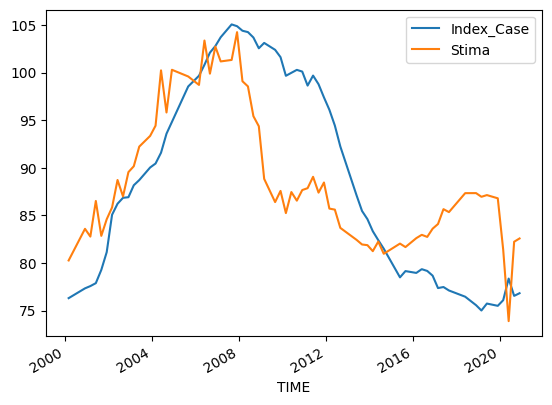

In [ ]:
Train['Stima'] =  (betha[0] * Train.Lavoratori + betha[1] * Train.Tassi + betha[2] * Train.Permessi + betha[3] * Train.PIL + betha[4] * Train.Popolazione + betha[5] * Train.Turisti[i]) 
ax = Train.plot('TIME' , 'Index_Case')
Train.plot('TIME' , 'Stima' , ax = ax)

In [ ]:
tot.Index_Case.corr(tot.Permessi)

0.5703260496298036